<a href="https://colab.research.google.com/github/junweiluo/HandsonMLPractice/blob/master/Chapter15Ex01_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape # this is a typical seq2vec RNN model as from the predictor and target shape. 50 to 1.

((7000, 50, 1), (7000, 1))

In [5]:
X_train[0:1,0:1,:]

array([[[0.4596948]]], dtype=float32)

In [6]:
y_train[:2,0]

array([-0.35489398,  0.11629631], dtype=float32)

Saving figure time_series_plot


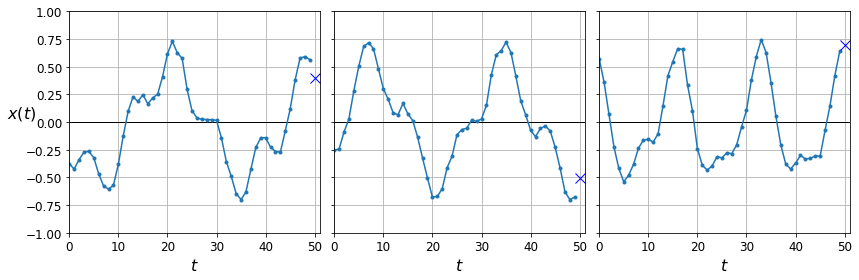

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

Simple RNN - forecasting one step

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(units= 10, input_shape=[None, 1]) # input shape is none because we don't know how many time steps.
    # The 1 in input shape correspondes to the last 1 in X_train and y_train.
    # the number of neurons (units) can be modified without other changes.
    # The number of neurons is only within a cell and is consistent across all time steps.
    # default function: hyperbolic tangent
    # this is a univariate time series, forecasting only one result.
])

In [11]:
model.summary() # no. of parameters = 1 * 10 (neuron last layer * no. of units) +10 * 10 (no. of units * no. of units) +  10 (bias)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [12]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0722 - val_loss: 0.0227
Epoch 2/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0169 - val_loss: 0.0144
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0123 - val_loss: 0.0140
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0114 - val_loss: 0.0125
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 7/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 8/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 9/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 10/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0086 - val_lo

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0066


0.006600305438041687

In [0]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

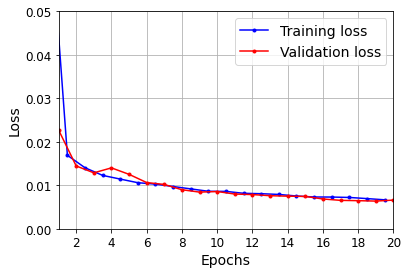

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Deep RNN - Seq2Seq or Seq2Vec

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(5, return_sequences=True), #return_sequence parameter decides returns a sequence as input.
    keras.layers.SimpleRNN(1) # This returns only last output (vec) since we don't set return_sequences = True. Default is False.
    # units=1 because we only predict one univariant.  Preferably, we should use Dense layer if predict only one.
])

In [35]:
model.summary() # second layer param = 5 * 20 (linking 2 layers) + 5 * 5 (neurons **) + 5 (bias)
# first layer 1 * 20 (input neuron * first neuron) + 20 * 20 (layer neuron ** ) + 20 bias
# third layer 5 * 1 + 1 * ! + 1

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, None, 5)           130       
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, 1)                 7         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, # let me try batch size and see if it works.
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 2/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 8/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 19s 89ms/step - loss: 0.003

In [26]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0065


0.006513596512377262

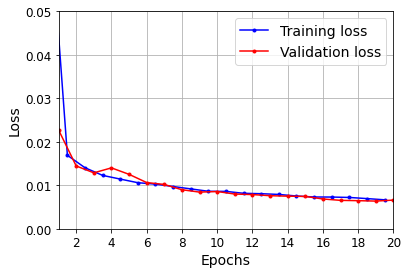

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

DNN only returns last output (Dense Layer).  Sec2Vec

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # Since next layer is not RNN, return_sequences should set to false.
    keras.layers.Dense(1) # this only returns last output.  Seq2Vec.  And we can choose other activations.
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 13s 61ms/step - loss: 0.003

Deep RNN - forecasting several steps using the one-step model.

In [0]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [37]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


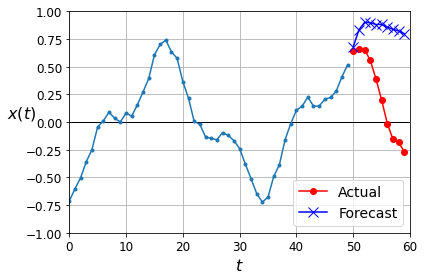

In [38]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

RNN - predict next ten steps at onece

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [0]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [41]:
Y_pred.shape

(2000, 10)

In [42]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.9199434

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), # this is a linear model
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0222

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # predict 10 outputs in one shot.
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 13s 58ms/step - loss: 0.011

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

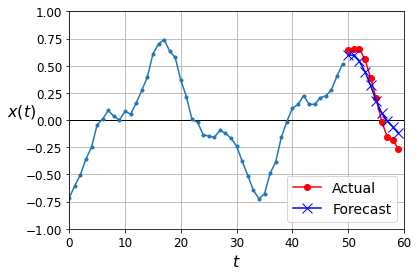

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Deep RNN - predict 10 periods but each and every time step.  Not at once
This will allow more error gradients through the model.
Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [48]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

Next is the real seq2seq by using TimeDistributed Layer wrapper.

In [0]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # Even this layer should set return_sequences=True
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # The only difference is to output one period at one time step.
])

In [50]:
model.summary() # summary is same

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [51]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1]) # Has to define a special loss

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 62ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0351 - val_last_time_step_mse: 0.0243
Epoch 3/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0323 - last_time_step_mse: 0.0211 - val_loss: 0.0290 - val_last_time_step_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0294 - last_time_step_mse: 0.0181 - val_loss: 0.0278 - val_last_time_step_mse: 0.0157
Epoch 5/20
219/219 [==============================] - 13s 62ms/step - loss: 0.0273 - last_time_step_mse: 0.0154 - val_loss: 0.0272 - val_last_time_step_mse: 0.0175
Epoch 6/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0249 - last_time_step_mse: 0.0121 - val_loss: 0.0252 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/2

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

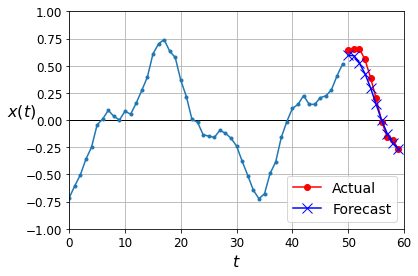

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()